In [ ]:
# import os
# os.chdir('/home/reggie/cosmo_learn')

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cosmo_learn.cosmo_learn import *

### One mock

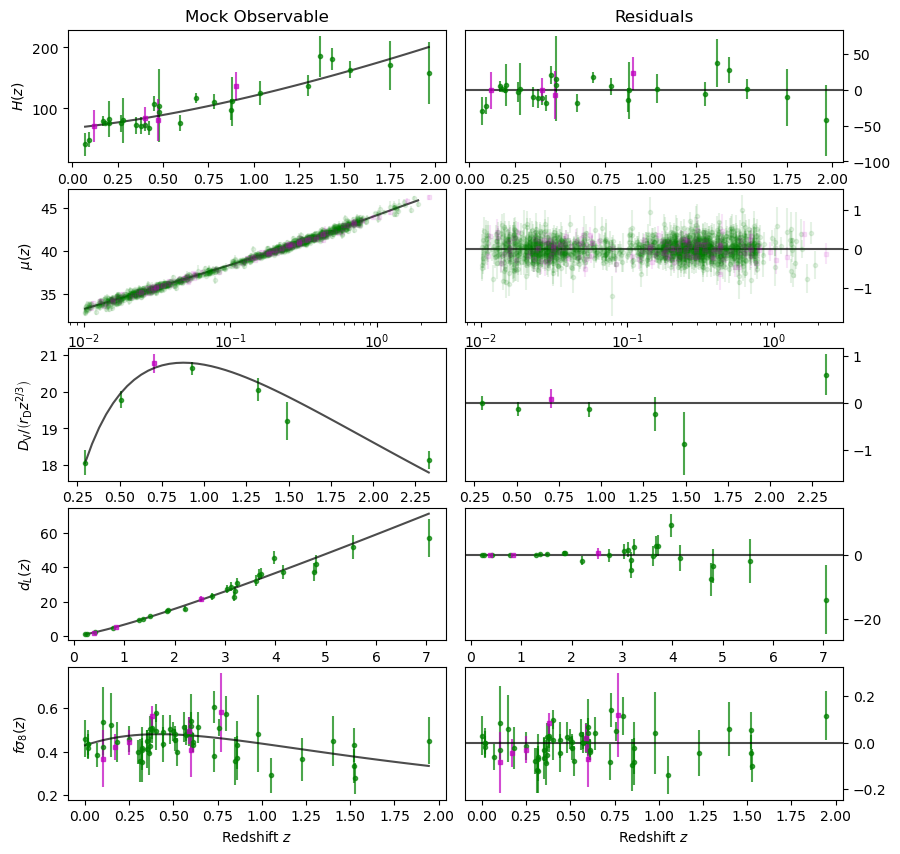

In [3]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

# fig, ax=my_cosmo_learn.show_mocks(show_input=True) # only mocks, no residuals
fig, ax=my_cosmo_learn.show_mocks_and_residuals(show_input=True, label_train=None, label_test=None)
fig.subplots_adjust(wspace=0.05)
plt.show()

### Multiple mocks, fixed random seed

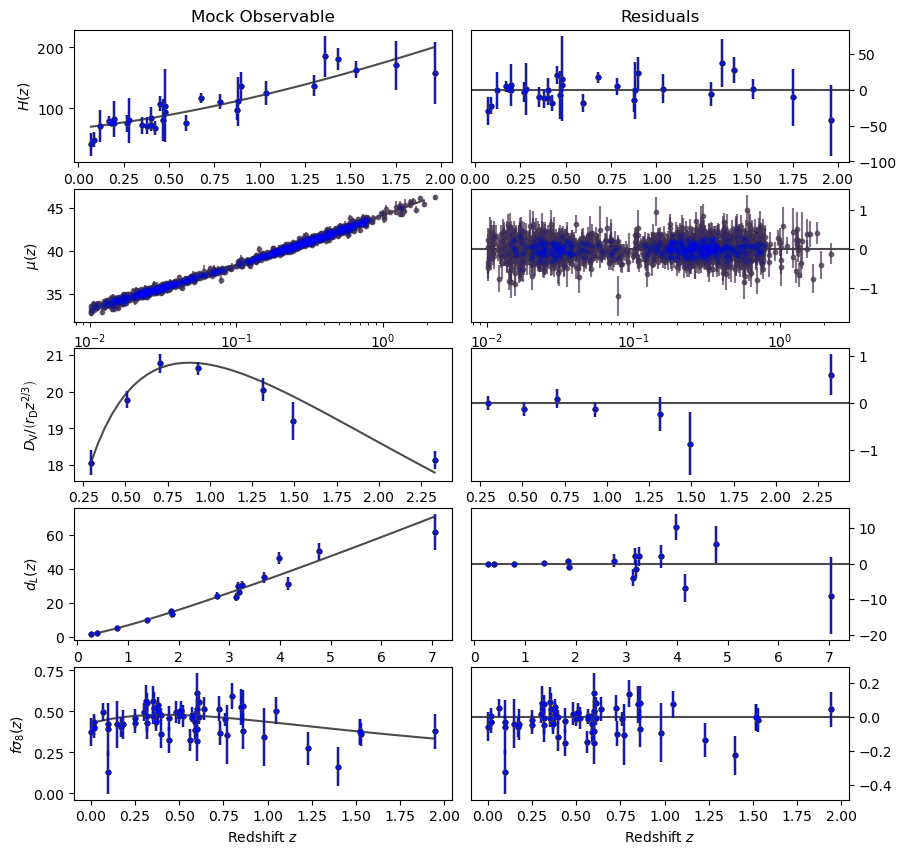

In [3]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

# fig, ax=my_cosmo_learn.show_mocks(show_input=True) # only mocks, no residuals
fig, ax=my_cosmo_learn.show_mocks_and_residuals(show_input=True, fmt_train='go', fmt_test='go')
fig.subplots_adjust(wspace=0.05)

# loop with fixed random seed
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for rs in range(10):
    my_cosmo_learn_rs=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
    my_cosmo_learn_rs.make_mock(mock_keys=mock_keys)
    color = colors[rs % len(colors)]
    my_cosmo_learn_rs.show_mocks_and_residuals(ax=ax, fmt_train=f'{color}o', fmt_test=f'{color}o')
plt.show()

### Multiple mocks, changing random seed

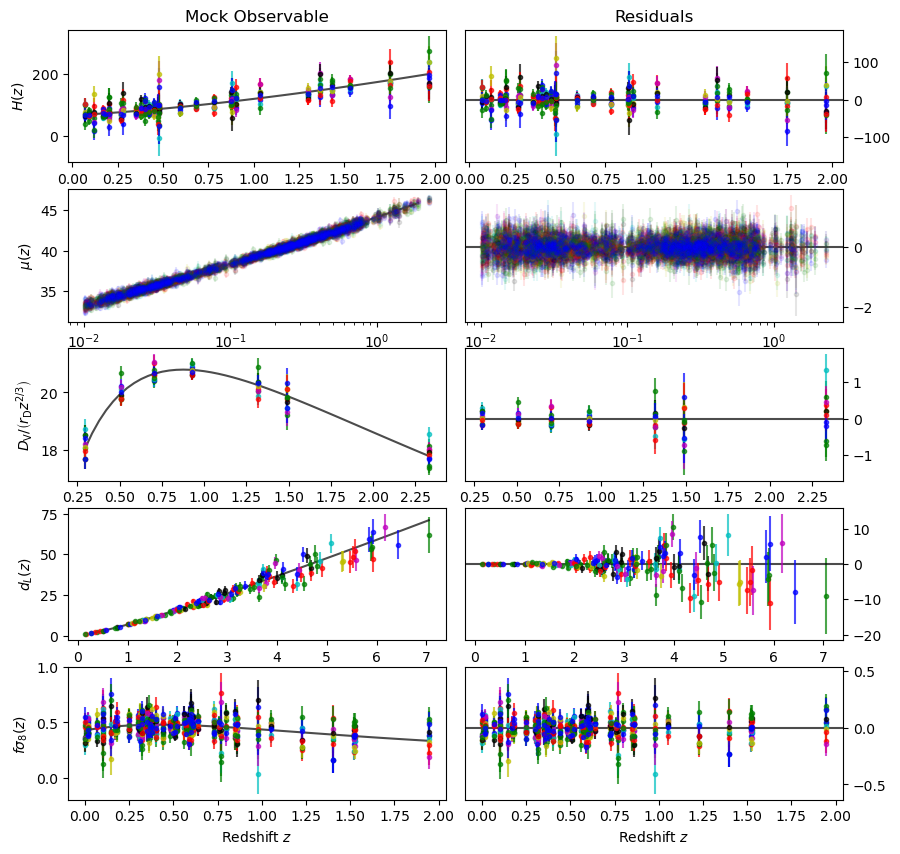

In [4]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

# fig, ax=my_cosmo_learn.show_mocks(show_input=True) # only mocks, no residuals
fig, ax=my_cosmo_learn.show_mocks_and_residuals(show_input=True, fmt_train='go', fmt_test='go')
fig.subplots_adjust(wspace=0.05)

# loop with changing seed
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for rs in range(10):
    my_cosmo_learn_rs=CosmoLearn([H0, Om0, w0, s8], seed=rs)
    my_cosmo_learn_rs.make_mock(mock_keys=mock_keys)
    color = colors[rs % len(colors)]
    my_cosmo_learn_rs.show_mocks_and_residuals(ax=ax, fmt_train=f'{color}o', fmt_test=f'{color}o')
plt.show()

### GP/BRR Reconstruction

In [2]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
# mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
#            'BrightSirens', 'RedshiftSpaceDistorsions']
mock_keys=['CosmicChronometers', 'SuperNovae', \
           'BrightSirens', 'RedshiftSpaceDistorsions']

my_cosmo_learn.make_mock(mock_keys=mock_keys)
my_cosmo_learn.train_gp()
my_cosmo_learn.train_brr()

/Users/reginaldchristianbernardo/miniconda3/envs/cosmo/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/reginaldchristianbernardo/miniconda3/envs/cosmo/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


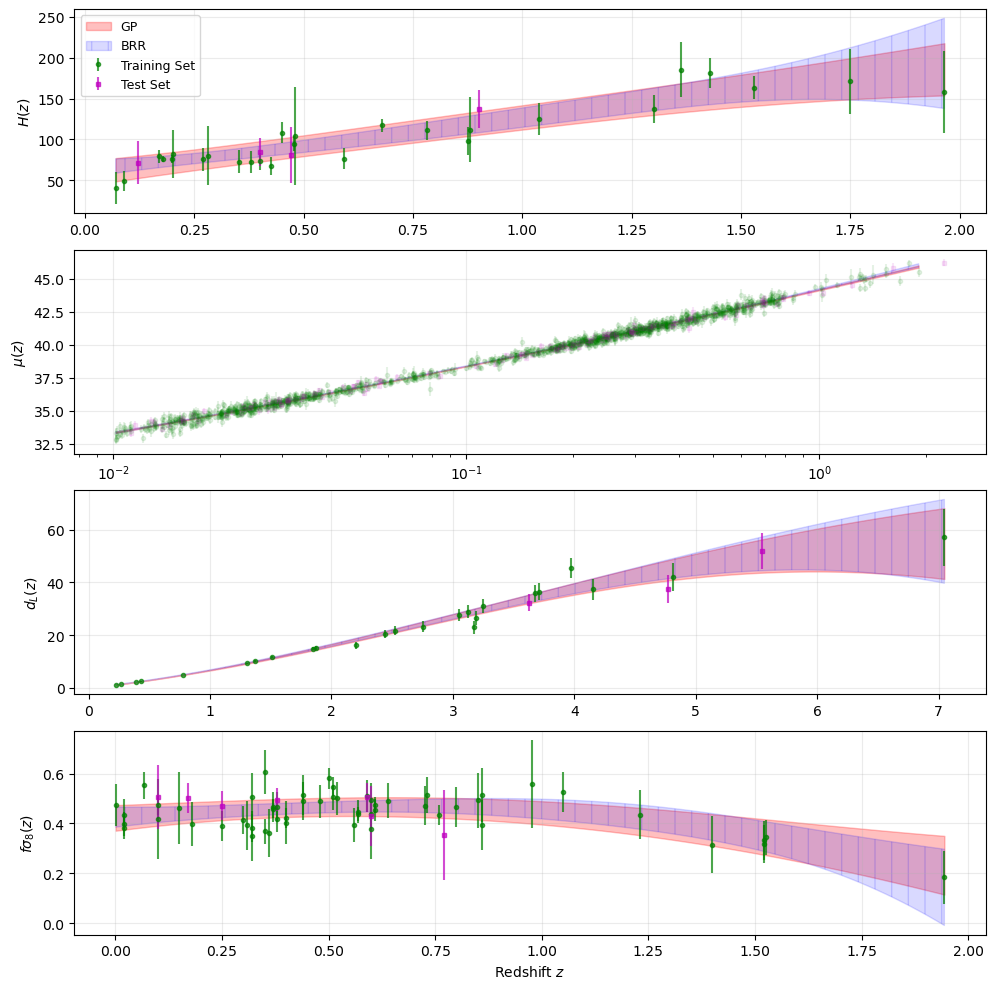

In [3]:
fig, ax=my_cosmo_learn.show_mocks(show_input=False)
my_cosmo_learn.show_trained_ml(ax=ax, method='GP', label='GP')
my_cosmo_learn.show_trained_ml(ax=ax, method='BRR', color='blue', alpha=0.15, hatch='|', label='BRR')

[ax[i].grid(True, alpha=0.25) for i in range(len(my_cosmo_learn.mock_data.keys()))]
ax[0].legend(loc='upper left', prop={'size': 9})
fig.tight_layout(); fig.subplots_adjust(hspace=0.18)
plt.show()

### ANN

ANN training w/ CosmicChronometers data


2024-12-11 17:10:48.667549: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ANN training w/ SuperNovae data
ANN training w/ BrightSirens data
ANN training w/ RedshiftSpaceDistorsions data


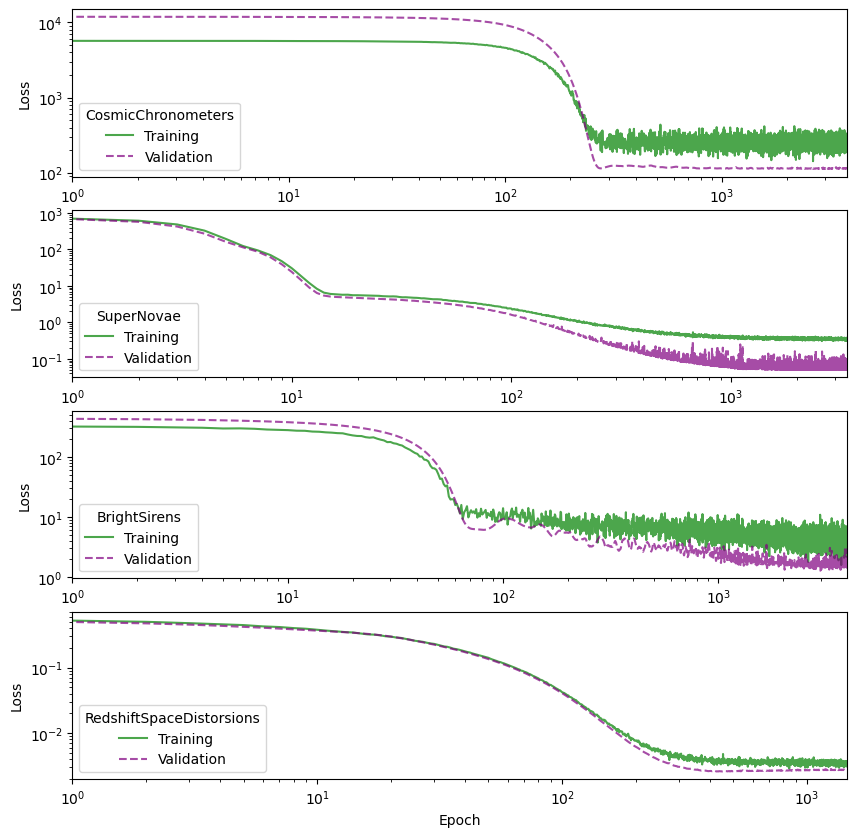

In [2]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
# mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
#            'BrightSirens', 'RedshiftSpaceDistorsions']
mock_keys=['CosmicChronometers', 'SuperNovae', \
           'BrightSirens', 'RedshiftSpaceDistorsions']

my_cosmo_learn.make_mock(mock_keys=mock_keys)
my_cosmo_learn.init_ann()
my_cosmo_learn.train_ann(verbose=0)
my_cosmo_learn.show_ann_loss()
plt.show()

4/4 [==============================] - 0s 796us/step


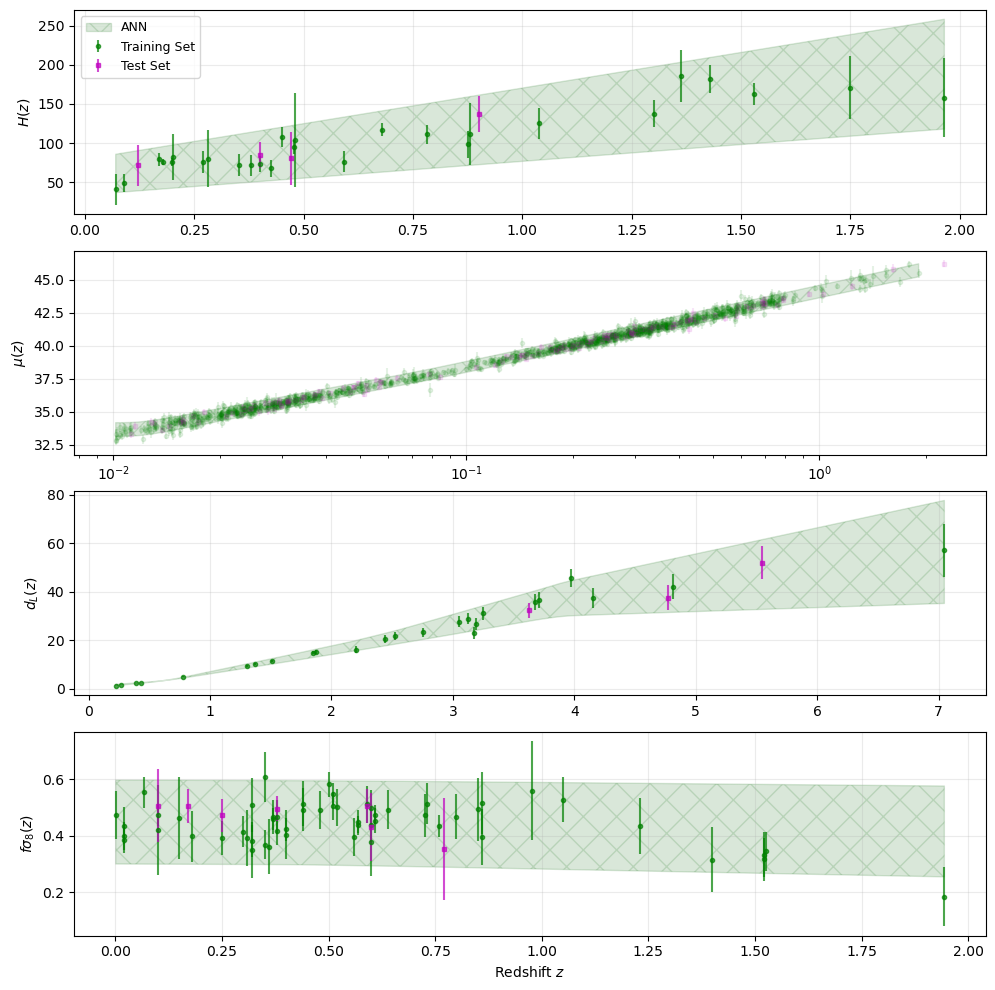

In [9]:
fig, ax=my_cosmo_learn.show_mocks(show_input=False)
my_cosmo_learn.show_trained_ml(ax=ax, method='ANN', color='darkgreen', alpha=0.15, hatch='x', label='ANN')

[ax[i].grid(True, alpha=0.25) for i in range(len(my_cosmo_learn.mock_data.keys()))]
ax[0].legend(loc='upper left', prop={'size': 9})
fig.tight_layout(); fig.subplots_adjust(hspace=0.18)
plt.show()

### MCMC and GA-Fisher

In [4]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
# mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
#            'BrightSirens', 'RedshiftSpaceDistorsions']
mock_keys=['CosmicChronometers', 'SuperNovae', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

In [5]:
prior_dict={'H0_min': 0, 'H0_max': 100, 'Om0_min': 0, 'Om0_max': 1, \
            'w0_min': -10, 'w0_max': 10, 's8_min': 0.2, 's8_max': 1.5}
rd_fid_prior={'mu': 147.46, 'sigma': 0.28}
llprob=lambda x: my_cosmo_learn.llprob_wcdm(x, prior_dict=prior_dict, rd_fid_prior=rd_fid_prior)

p0=[70, 0.3, -1, 0.8, 147]
nwalkers=15; dres=[0.05, 0.005, 0.01, 0.01, 0.005]; nburn=100; nmcmc=2000
my_cosmo_learn.get_mcmc_samples(nwalkers, dres, llprob, p0, nburn=nburn, nmcmc=nmcmc)

Optimizing initial position...
... At [ 68.20532256   0.32053463  -1.12736345   0.8012537  147.45968652]
Running MCMC...


100%|██████████| 2000/2000 [00:41<00:00, 48.66it/s]

Done.
Mean acceptance fraction: 0.5514333333333333
Total time: 43.20746898651123
MCMC result:
    x[0] = 68.19979403153326 + 0.308574582318343 - 0.3061254627647685
    x[1] = 0.3226106480894625 + 0.020124417750697732 - 0.020889167365146233
    x[2] = -1.1350796710674276 + 0.07827565003235915 - 0.08169262448669712
    x[3] = 0.8014045908468739 + 0.016938961059666857 - 0.01736737964797397
    x[4] = 147.48061519869515 + 0.27334760315528683 - 0.27443347164140164


In [6]:
fitness_func=lambda x: -2*llprob(x)
prior_ga=[[prior_dict['H0_min'], prior_dict['H0_max']], [prior_dict['Om0_min'], prior_dict['Om0_max']], \
          [prior_dict['w0_min'], prior_dict['w0_max']], [prior_dict['s8_min'], prior_dict['s8_max']], \
          [rd_fid_prior['mu']-20*rd_fid_prior['sigma'], rd_fid_prior['mu']+20*rd_fid_prior['sigma']]]

# change ga hyperparameters via my_cosmo_learn.ga_params[key]=new_values
# some defaults: 'max_num_iteration'=1000, 'population_size'=100, 'mutation_probability'=0.3
my_cosmo_learn.get_gaFisher_samples(fitness_func, prior_ga, \
                                    llprob=llprob, nsamples=(nmcmc-nburn)*nwalkers)

|||||_____________________________________________ 9.4% GA is running...

/Users/reginaldchristianbernardo/miniconda3/envs/cosmo/lib/python3.11/site-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


|||||||||||||||||||||||||||||||||||||||||||_______ 85.5% GA is running...

/Users/reginaldchristianbernardo/Documents/rbrepos/cosmo_learn/cosmo_learn/cosmo_learn.py:208: RuntimeWarning: invalid value encountered in divide
  s8z=sigma8_0*dltz/dlt_0
/Users/reginaldchristianbernardo/Documents/rbrepos/cosmo_learn/cosmo_learn/cosmo_learn.py:197: RuntimeWarning: invalid value encountered in divide
  hypergeom_factor=hyp2f1(alpha+1, beta+1, gamma+1, 1 - (1/Omz))/hyp2f1(alpha, beta, gamma, 1 - (1/Omz))


 The best solution found:                                                                           
 [ 68.79711064   0.36407543  -1.34964259   0.80859602 147.43821199]

 Objective function:
 1511.063242690356

GA-Fisher result:
    x[0] = 68.79243856009847 + 0.3079439277283882 - 0.30720481857041193
    x[1] = 0.36407964044113617 + 0.018263713911677915 - 0.018360806231656424
    x[2] = -1.3496890219125883 + 0.09307903044595056 - 0.09148665667344469
    x[3] = 0.8084741348667177 + 0.016557826232419415 - 0.016551328830115786
    x[4] = 147.43610565126056 + 0.2756220972610208 - 0.27924867565195655


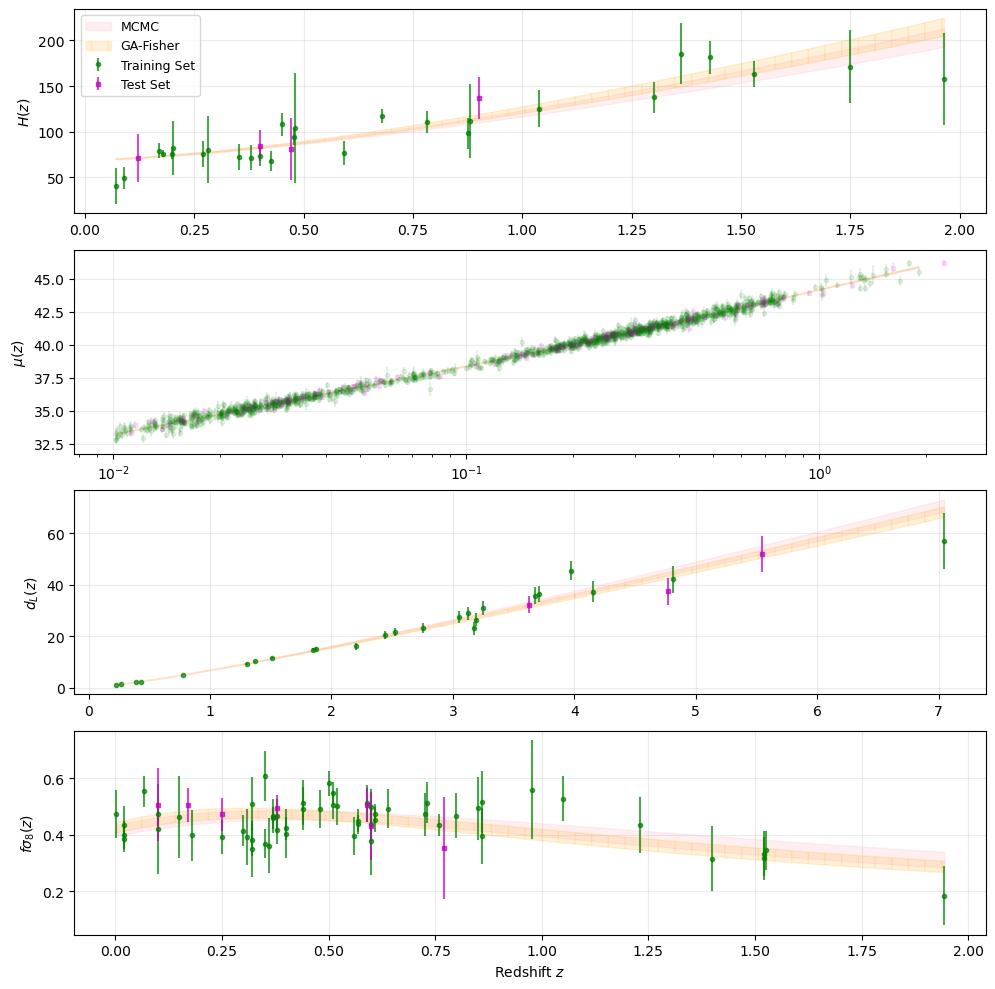

In [7]:
fig, ax=my_cosmo_learn.show_mocks(show_input=False)
my_cosmo_learn.show_bestfit_curve(ax=ax, method='MCMC', label='MCMC', color='pink')
my_cosmo_learn.show_bestfit_curve(ax=ax, method='GAFisher', color='orange', alpha=0.15, hatch='|', label='GA-Fisher')

[ax[i].grid(True, alpha=0.25) for i in range(len(my_cosmo_learn.mock_data.keys()))]
ax[0].legend(loc='upper left', prop={'size': 9})
fig.tight_layout(); fig.subplots_adjust(hspace=0.18)
plt.show()

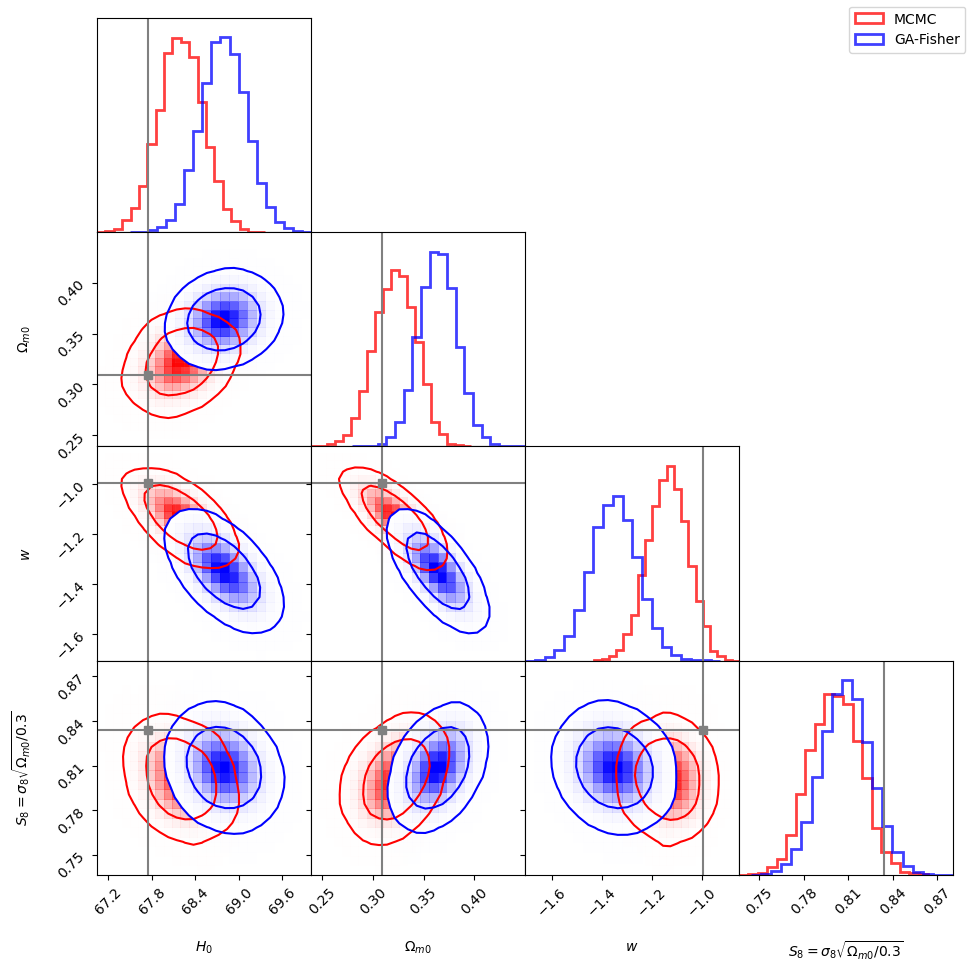

In [10]:
corner_plot = my_cosmo_learn.show_param_posterior(method='MCMC')
my_cosmo_learn.show_param_posterior(method='GAFisher', fig=corner_plot, color='blue', show_truth=True)

corner_plot.legend(['MCMC', 'GA-Fisher'], loc='upper right')
corner_plot.tight_layout(); corner_plot.subplots_adjust(hspace=0, wspace=0)
plt.show()